In [1]:
import sys
sys.path.append("..")

from models import UNet3d, AttnUNet3d
from loss_metric import *
from dataset_dataloader import *
from trainer import Trainer

In [2]:
class GlobalConfig:
    root_dir = '/home/mandrakedrink/edu/data'
    train_root_dir = 'home/mandrakedrink/edu/brats2021'
    test_root_dir = 'home/mandrakedrink/edu/brats2021'
    path_to_train_csv = '/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/train.csv'
    path_to_test_csv = '/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/test.csv'
    train_logs_path = None
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

In [49]:
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['NCR', 'ED', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['NCR', 'ED', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

In [76]:
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['NCR', 'ED', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['NCR', 'ED', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

def compute_scores_per_classes(model,
                               dataloader,
                               classes, threshold):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets,threshold)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets,threshold)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [5]:
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv).reset_index(drop=True)
    
    #train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    #val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    #df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )
    return dataloader

In [6]:
test_dataloader = get_dataloader(BratsDataset, config.path_to_test_csv, phase='valid', fold=0)
len(test_dataloader)

251

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def find_best_threshold(dataloader, model, metric_function, thresholds=np.linspace(0, 1, 10), classes=['NCR', 'ED', 'ET']):
    """
    Find the best threshold for each class using the given metric function (e.g., Dice).
    """
    best_thresholds = {}
    all_scores = {key: [] for key in classes}

    for threshold in thresholds:
        scores = compute_scores_per_classes(model, dataloader, classes, threshold)
        
        # Using the first metric function, which is assumed to be Dice for simplicity
        dice_scores = scores[0]

        for class_ in classes:
            # Average the dice score for this threshold
            avg_dice = np.mean(dice_scores[class_])
            all_scores[class_].append(avg_dice)

            if class_ not in best_thresholds or avg_dice > best_thresholds[class_]['score']:
                best_thresholds[class_] = {'threshold': threshold, 'score': avg_dice}

    return best_thresholds, all_scores

def visualize_best_thresholds(all_scores, thresholds, classes=['NCR', 'ED', 'ET']):
    """
    Visualize the Dice score over different thresholds.
    """
    plt.figure(figsize=(12, 7))
    for class_ in classes:
        plt.plot(thresholds, all_scores[class_], label=f'{class_} (best threshold: {best_thresholds[class_]["threshold"]:.2f})')
    
    plt.title('Dice Coefficient over Different Thresholds', fontsize=16)
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Dice Coefficient', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


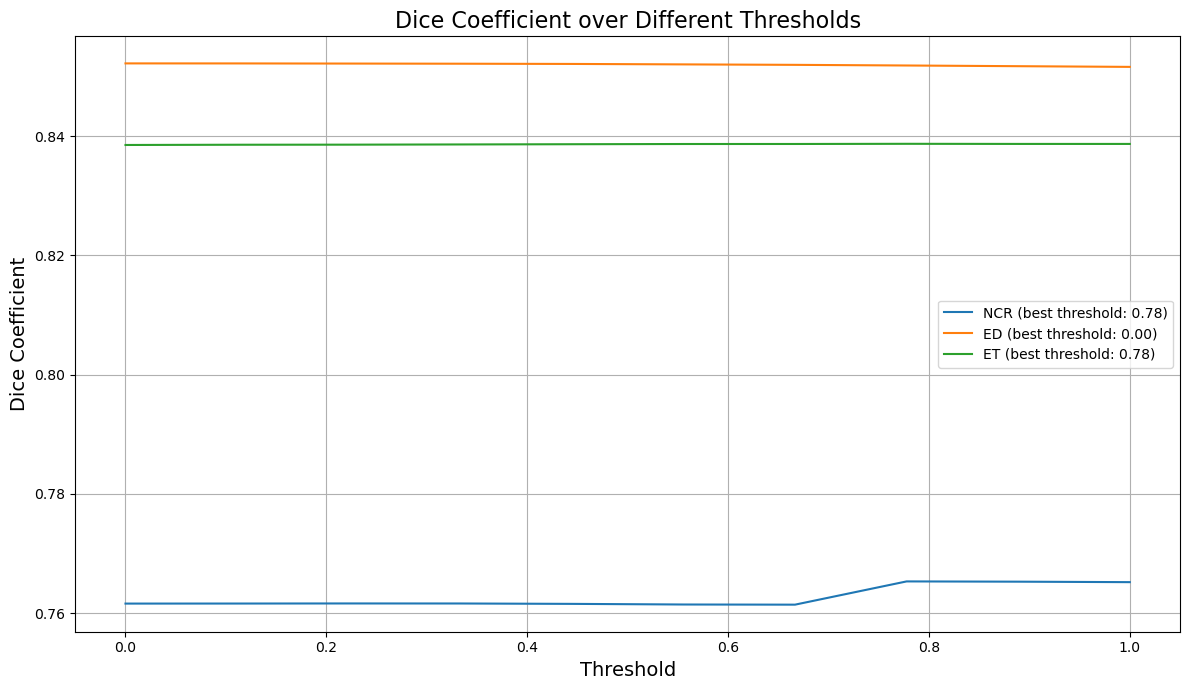

In [21]:
#%%time
best_thresholds, all_scores = find_best_threshold(test_dataloader, nodel, dice_coef_metric_per_classes)

# Visualize it
visualize_best_thresholds(all_scores, np.linspace(0, 1, 10))

In [8]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [1]:
best_thresholds

In [ ]:
all_scores


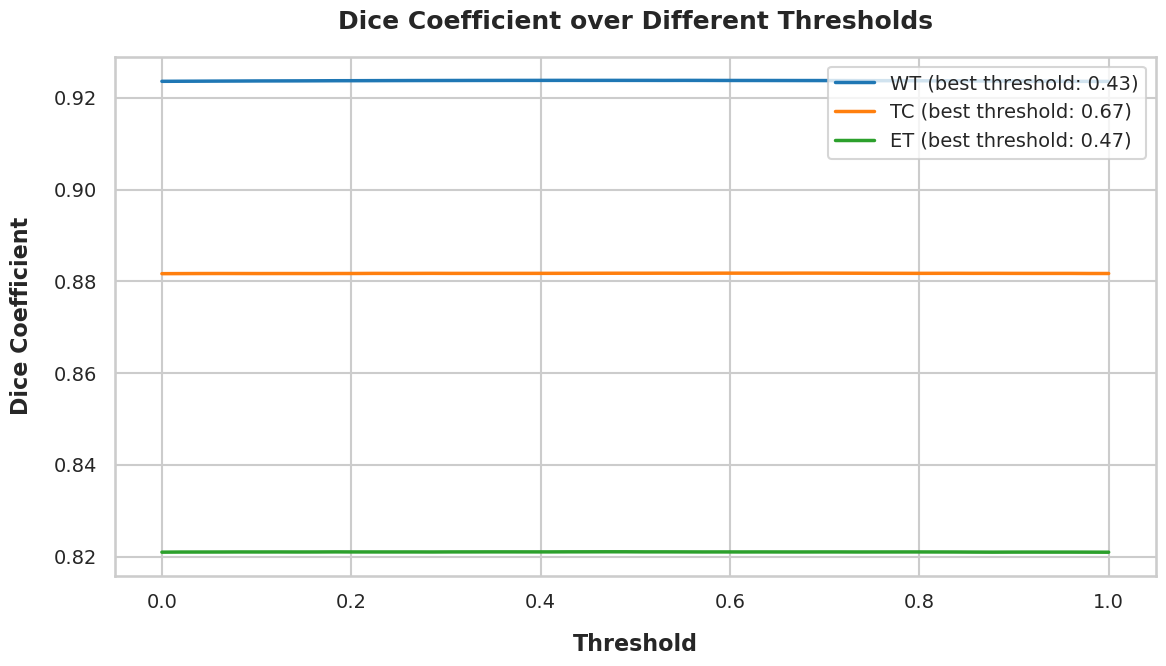

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_best_thresholds(all_scores, thresholds, classes=['WT', 'TC', 'ET']):
    """
    Visualize the Dice score over different thresholds with improved aesthetics.
    """
    # Set a classic style
    sns.set_style('whitegrid')
    
    # Create a color palette
    colors = sns.color_palette('tab10', len(classes))

    plt.figure(figsize=(12, 7))
    
    for idx, class_ in enumerate(classes):
        plt.plot(thresholds, all_scores[class_], label=f'{class_} (best threshold: {best_thresholds[class_]["threshold"]:.2f})', color=colors[idx], linewidth=2.5)
    
    plt.title('Dice Coefficient over Different Thresholds', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Threshold', fontsize=16, fontweight='bold', labelpad=15)
    plt.ylabel('Dice Coefficient', fontsize=16, fontweight='bold', labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14, loc='best')
    plt.tight_layout()
    
    # Uncomment the next line to save the figure in high resolution
    # plt.savefig('dice_coefficient_plot.png', dpi=300)

    plt.show()

# Assuming you already computed best_thresholds and all_scores
visualize_best_thresholds(all_scores, np.linspace(0, 1, 50))


# UNet

In [59]:
nodel = UNet3d(in_channels=4, n_classes=3, n_channels=48).to('cuda')
nodel.load_state_dict(torch.load("/home/mandrakedrink/edu/dyplom_work/brats2020/vanila_unet/best_model_98.pth"))
nodel.eval();
#/home/mandrakedrink/edu/data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_ValidationData

In [60]:
val_transform = Compose(
    [
        #LoadImaged(keys=["image", "label"]),
        #EnsureChannelFirstd(keys="image"),
        #EnsureTyped(keys=["image", "label"]),
        #ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [61]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    nodel, test_dataloader, ['NCR', 'ED', 'ET'], 0.5
    )

CPU times: user 2min 21s, sys: 21.8 s, total: 2min 43s
Wall time: 2min 32s


In [62]:
#... the GD-enhancing tumor (ET — label 4), the peritumoral edematous/invaded tissue (ED — label 2), and the necrotic tumor core (NCR — label 1).


In [63]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['NCR dice', 'ED dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['NCR jaccard', 'ED jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['NCR dice', 'NCR jaccard', 
                                      'ED dice', 'ED jaccard', 
                                      'ET dice', 'ET jaccard']]#from skimage.filters import threshold_otsu
val_metics_df.sample(5)

,NCR dice,NCR jaccard,ED dice,ED jaccard,ET dice,ET jaccard
238,0.896239,0.811986,0.915426,0.844043,0.974333,0.949950
114,0.954576,0.913099,0.968692,0.939286,0.971094,0.943812
19,0.860470,0.755110,0.939134,0.885252,0.907141,0.830062
31,0.925847,0.861931,0.964133,0.930749,0.964289,0.931041
138,0.937936,0.883125,0.801114,0.668215,0.963633,0.929818


In [79]:
#... the GD-enhancing tumor (ET — label 4), the peritumoral edematous/invaded tissue (ED — label 2), and the necrotic tumor core (NCR — label 1).

#and the necrotic tumor core (NCR — label 1). 
#the peritumoral edematous/invaded tissue 
#(ED — label 2) the GD-enhancing tumor (ET — label 4),


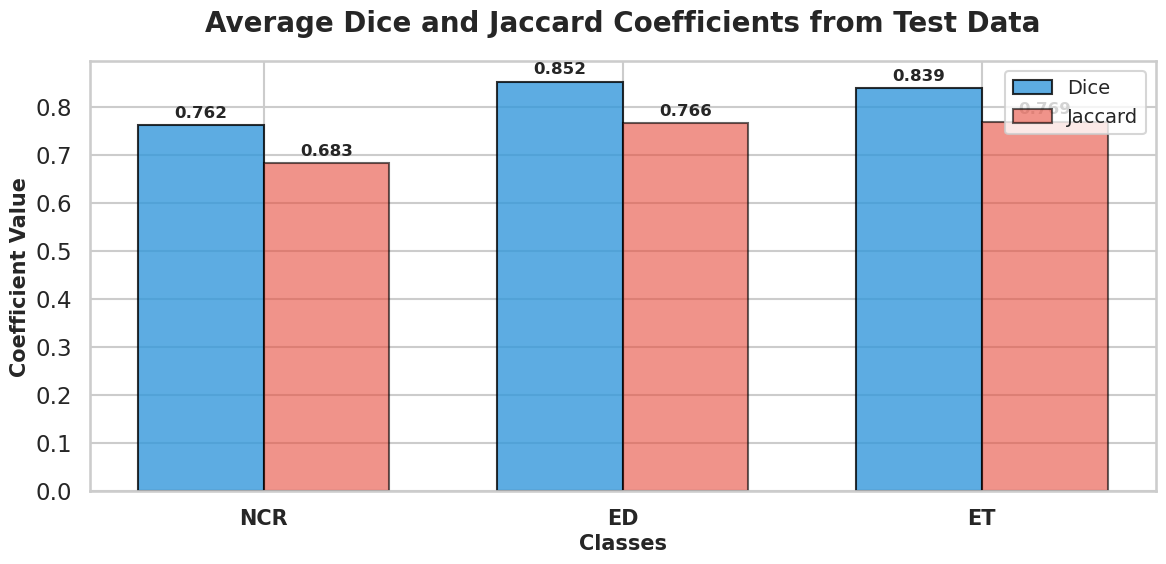

In [64]:
# Подготовка данных
means = val_metics_df.mean()
classes = ['NCR', 'ED', 'ET']
dice_means = [means[f"{cls} dice"] for cls in classes]
jaccard_means = [means[f"{cls} jaccard"] for cls in classes]

bar_width = 0.35
indices = np.arange(len(classes))

# Визуализация
fig, ax = plt.subplots(figsize=(12, 6))

# Визуализируем Dice коэффициенты
dice_bars = ax.bar(indices - bar_width/2, dice_means, bar_width, label='Dice', alpha=0.8, color='#3498db', edgecolor='black')

# Визуализируем Jaccard коэффициенты, но позиционируем их так, чтобы они были "наложены" на Dice
jaccard_bars = ax.bar(indices + bar_width/2, jaccard_means, bar_width, label='Jaccard', alpha=0.6, color='#e74c3c', edgecolor='black')

# Настройка оси X
ax.set_xlabel('Classes', fontsize=15, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=15, weight='bold')
ax.set_title('Average Dice and Jaccard Coefficients from Test Data', fontsize=20, y=1.05, weight='bold')
ax.set_xticks(indices)
ax.set_xticklabels(classes, fontsize=15, fontweight='bold')
ax.legend(fontsize=14, loc='best')

# Улучшения для статьи: делаем границы более видимыми, добавляем значения над столбцами
for bars in [dice_bars, jaccard_bars]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

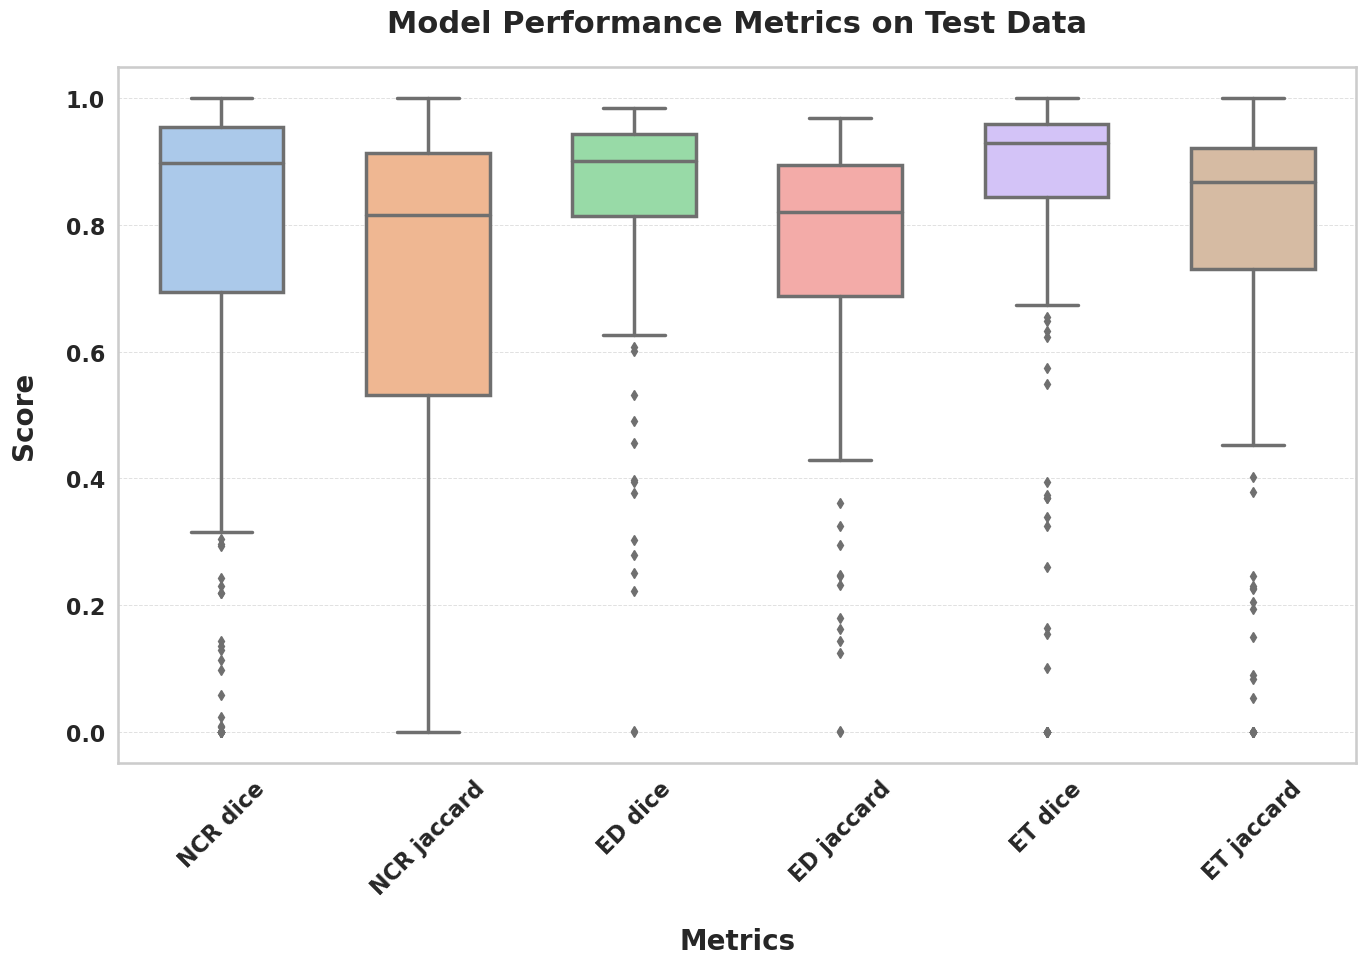

In [12]:
# Установка стиля и контекста для графика качества публикации
sns.set_style("whitegrid")
sns.set_context("talk")

# Подготовка фигуры и осей
fig, ax = plt.subplots(figsize=(14, 10))

# Создание boxplot
palette = sns.color_palette("pastel")
sns.boxplot(data=val_metics_df, ax=ax, palette=palette, width=0.6, linewidth=2.5)

# Декорирование графика
ax.set_title("Model Performance Metrics on Test Data", fontsize=22, fontweight='bold', pad=25)
ax.set_ylabel("Score", fontsize=20, fontweight='bold', labelpad=20)
ax.set_xlabel("Metrics", fontsize=20, fontweight='bold', labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=6)
plt.xticks(rotation=45, fontweight='bold')
plt.yticks(fontweight='bold')

# Добавление горизонтальных линий для лучшей читаемости
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

# Обеспечиваем пространство между элементами графика для чистоты и читаемости
plt.tight_layout()

# Сохранение рисунка (раскомментируйте для сохранения)
# plt.savefig("metrics_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

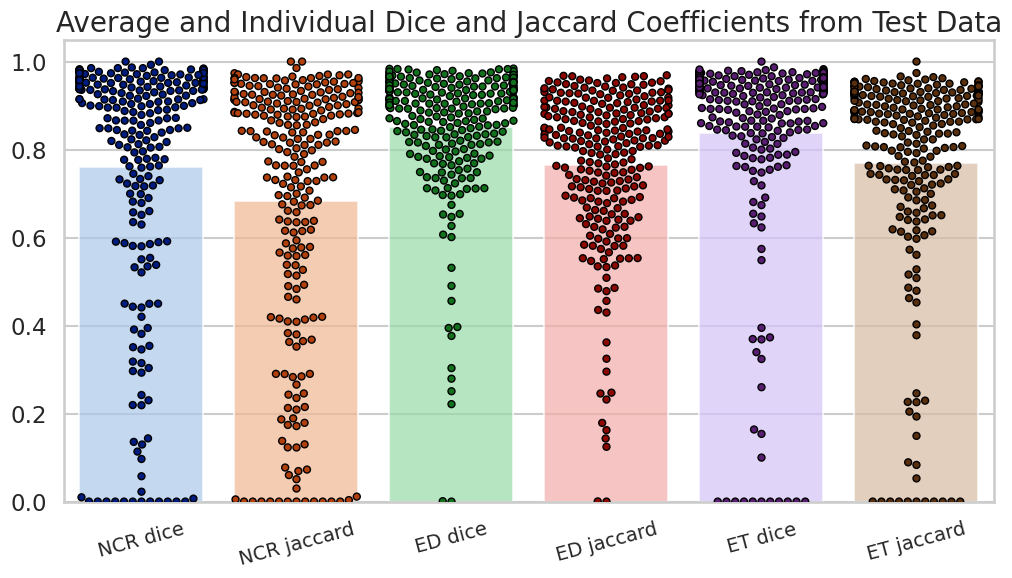

In [24]:
# Устанавливаем контрастные палитры для barplot и swarmplot
bar_palette = sns.color_palette("pastel", len(means.index))
swarm_palette = sns.color_palette("dark", len(means.index))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=means.index, y=means.values, palette=bar_palette, ax=ax, alpha=0.7)
sns.swarmplot(data=val_metics_df, palette=swarm_palette, ax=ax, edgecolor='black', linewidth=1)
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)
ax.set_title("Average and Individual Dice and Jaccard Coefficients from Test Data", fontsize=20)
plt.show()


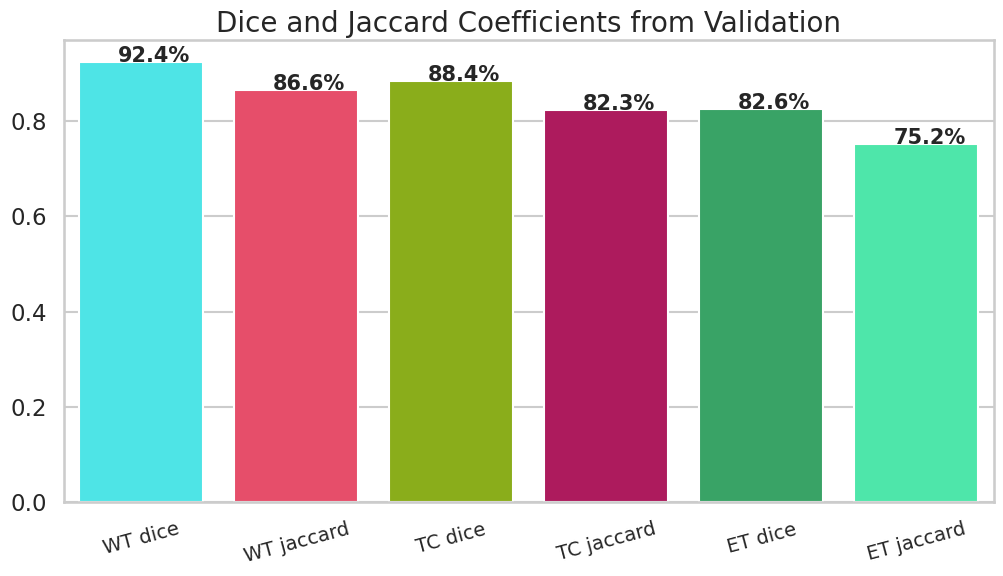

In [76]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF'] # AttnUnet 115 epoch
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

# AttnUNet

In [77]:
nodel = AttnUNet3d(in_channels=4, n_classes=3, n_channels=48).to('cuda')
#nodel.load_state_dict(torch.load("/home/mandrakedrink//edu/data/Uber Data/Rider/brats2020/vanila_unet/unet_att/best_model_177.pth"))
nodel.load_state_dict(torch.load("/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/best_model_84.pth"))
nodel.eval();

#/home/mandrakedrink/edu/data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_ValidationData
#edu/data/Uber Data/Rider/brats2020/vanila_unet/unet_att/best_model_95.pth

In [78]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    nodel, test_dataloader, ['NCR', 'ED', 'ET'], 0.
    )

CPU times: user 2min 36s, sys: 22.9 s, total: 2min 59s
Wall time: 2min 47s


In [79]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['NCR dice', 'ED dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['NCR jaccard', 'ED jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['NCR dice', 'NCR jaccard', 
                                      'ED dice', 'ED jaccard', 
                                      'ET dice', 'ET jaccard']]#from skimage.filters import threshold_otsu
val_metics_df.sample(5)

,NCR dice,NCR jaccard,ED dice,ED jaccard,ET dice,ET jaccard
111,0.297411,0.174682,0.742384,0.590311,0.900631,0.819225
117,0.949579,0.903998,0.936493,0.880571,0.838443,0.721827
172,0.059201,0.030503,0.574781,0.403293,0.842714,0.728182
112,0.842903,0.728464,0.964299,0.931059,0.965931,0.934107
194,0.812345,0.683991,0.939036,0.885078,0.884255,0.792524


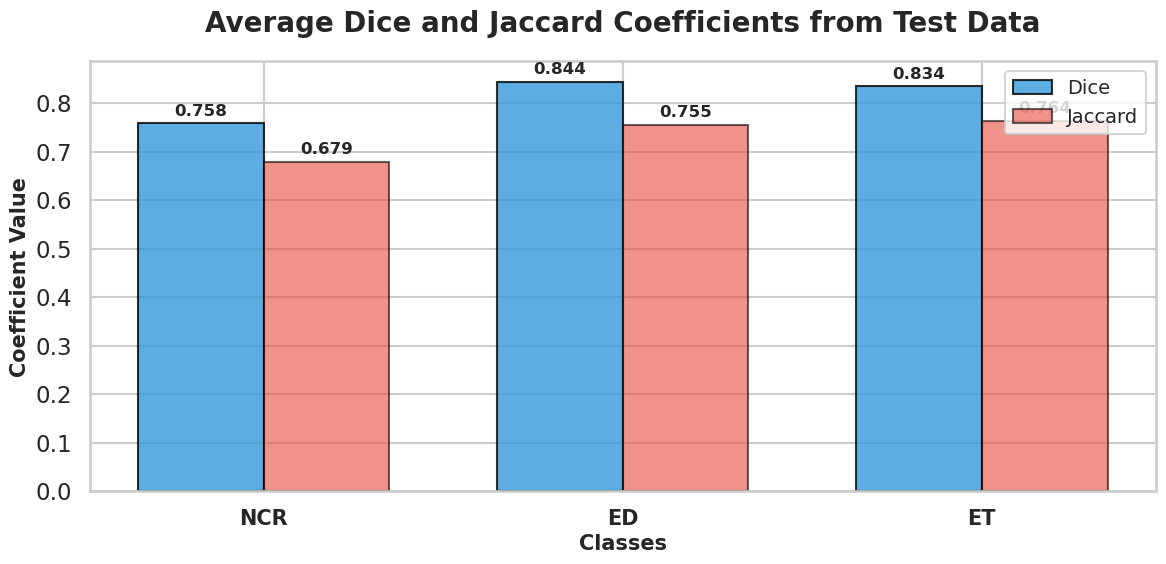

In [80]:
# Подготовка данных
means = val_metics_df.mean()
classes = ['NCR', 'ED', 'ET']
dice_means = [means[f"{cls} dice"] for cls in classes]
jaccard_means = [means[f"{cls} jaccard"] for cls in classes]

bar_width = 0.35
indices = np.arange(len(classes))

# Визуализация
fig, ax = plt.subplots(figsize=(12, 6))

# Визуализируем Dice коэффициенты
dice_bars = ax.bar(indices - bar_width/2, dice_means, bar_width, label='Dice', alpha=0.8, color='#3498db', edgecolor='black')

# Визуализируем Jaccard коэффициенты, но позиционируем их так, чтобы они были "наложены" на Dice
jaccard_bars = ax.bar(indices + bar_width/2, jaccard_means, bar_width, label='Jaccard', alpha=0.6, color='#e74c3c', edgecolor='black')

# Настройка оси X
ax.set_xlabel('Classes', fontsize=15, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=15, weight='bold')
ax.set_title('Average Dice and Jaccard Coefficients from Test Data', fontsize=20, y=1.05, weight='bold')
ax.set_xticks(indices)
ax.set_xticklabels(classes, fontsize=15, fontweight='bold')
ax.legend(fontsize=14, loc='best')

# Улучшения для статьи: делаем границы более видимыми, добавляем значения над столбцами
for bars in [dice_bars, jaccard_bars]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()# attn


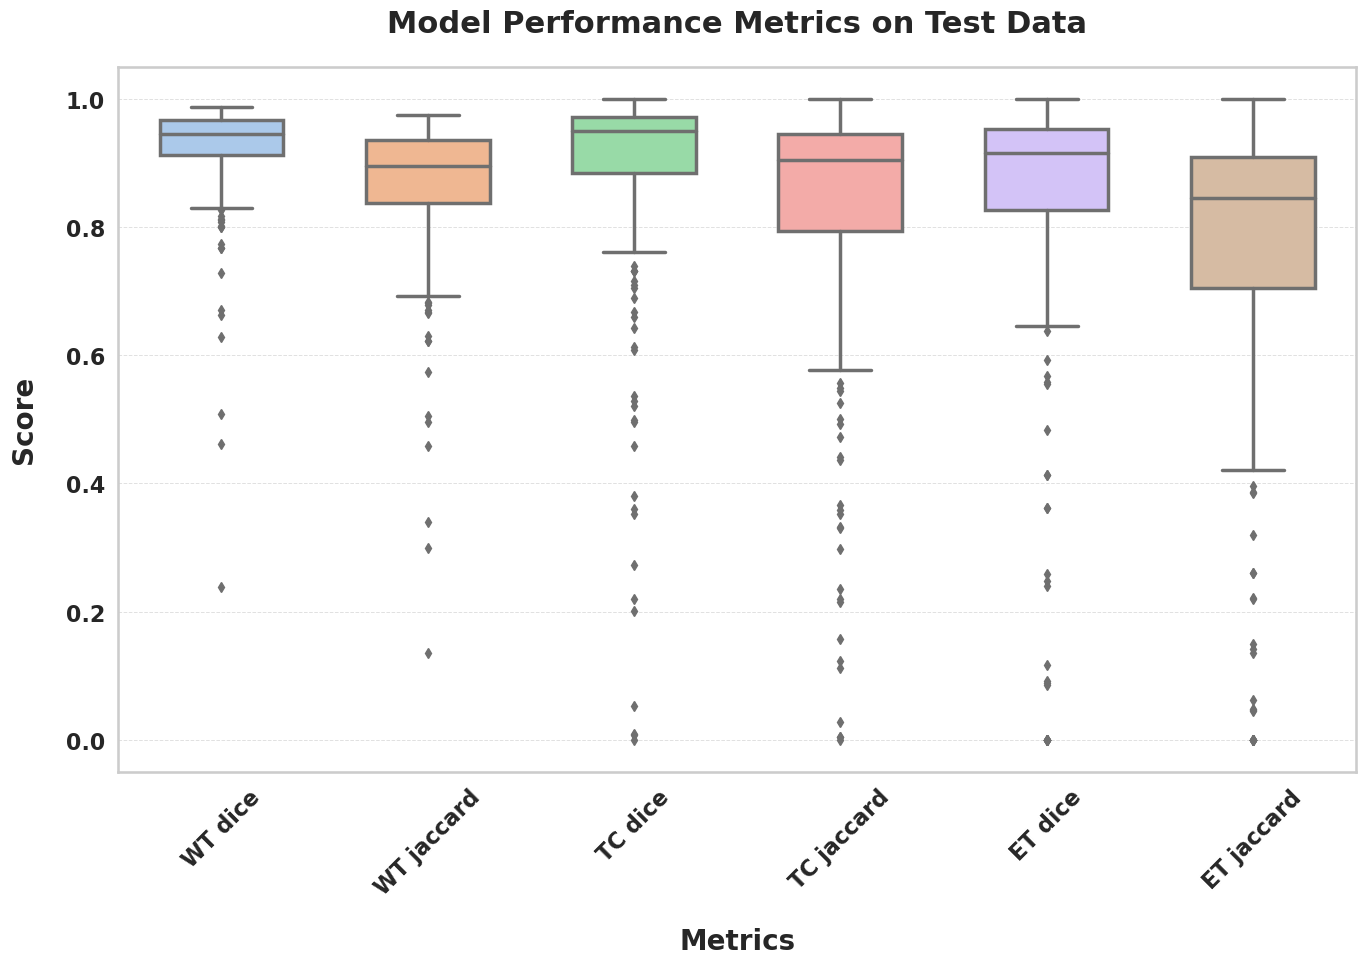

In [56]:
# Установка стиля и контекста для графика качества публикации
sns.set_style("whitegrid")
sns.set_context("talk")

# Подготовка фигуры и осей
fig, ax = plt.subplots(figsize=(14, 10))

# Создание boxplot
palette = sns.color_palette("pastel")
sns.boxplot(data=val_metics_df, ax=ax, palette=palette, width=0.6, linewidth=2.5)

# Декорирование графика
ax.set_title("Model Performance Metrics on Test Data", fontsize=22, fontweight='bold', pad=25)
ax.set_ylabel("Score", fontsize=20, fontweight='bold', labelpad=20)
ax.set_xlabel("Metrics", fontsize=20, fontweight='bold', labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=6)
plt.xticks(rotation=45, fontweight='bold')
plt.yticks(fontweight='bold')

# Добавление горизонтальных линий для лучшей читаемости
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

# Обеспечиваем пространство между элементами графика для чистоты и читаемости
plt.tight_layout()

# Сохранение рисунка (раскомментируйте для сохранения)
# plt.savefig("metrics_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()


# Ensemble

In [92]:
nodel1 = UNet3d(in_channels=4, n_classes=3, n_channels=48).to('cuda')
#nodel.load_state_dict(torch.load("/home/mandrakedrink//edu/data/Uber Data/Rider/brats2020/vanila_unet/unet_att/best_model_177.pth"))
nodel1.load_state_dict(torch.load("/home/mandrakedrink/edu/dyplom_work/brats2020/vanila_unet/best_model_98.pth"))
nodel1.eval();

In [93]:
nodel2 = AttnUNet3d(in_channels=4, n_classes=3, n_channels=48).to('cuda')
#nodel.load_state_dict(torch.load("/home/mandrakedrink//edu/data/Uber Data/Rider/brats2020/vanila_unet/unet_att/best_model_177.pth"))
nodel2.load_state_dict(torch.load("/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/best_model_84.pth"))
nodel2.eval();

In [94]:
def compute_scores_per_classes(model1,model2,
                               dataloader,
                               classes, threshold):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits1 = model1(imgs)
            logits1 = logits1.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            logits2 = model2(imgs)
            logits2 = logits2.detach().cpu().numpy()
            
            ensemble_logits = ( (logits1 * 0.55) + (logits2 * 0.45))
        
            dice_scores = dice_coef_metric_per_classes(ensemble_logits, targets,threshold)
            iou_scores = jaccard_coef_metric_per_classes(ensemble_logits, targets,threshold)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [95]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    nodel1,nodel2, test_dataloader, ['NCR', 'ED', 'ET'], 0.6
    )

CPU times: user 4min 21s, sys: 34.1 s, total: 4min 55s
Wall time: 4min 43s


In [96]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['NCR dice', 'ED dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['NCR jaccard', 'ED jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['NCR dice', 'NCR jaccard', 
                                      'ED dice', 'ED jaccard', 
                                      'ET dice', 'ET jaccard']]#from skimage.filters import threshold_otsu
val_metics_df.sample(5)

,NCR dice,NCR jaccard,ED dice,ED jaccard,ET dice,ET jaccard
116,0.955260,0.914351,0.937554,0.882448,0.842803,0.728314
248,0.976927,0.954895,0.931246,0.871338,0.971772,0.945093
122,0.524192,0.355190,0.749635,0.599533,0.777068,0.635414
152,0.578298,0.406764,0.707573,0.547477,0.893549,0.807582
240,0.971514,0.944607,0.823708,0.700258,0.942612,0.891454


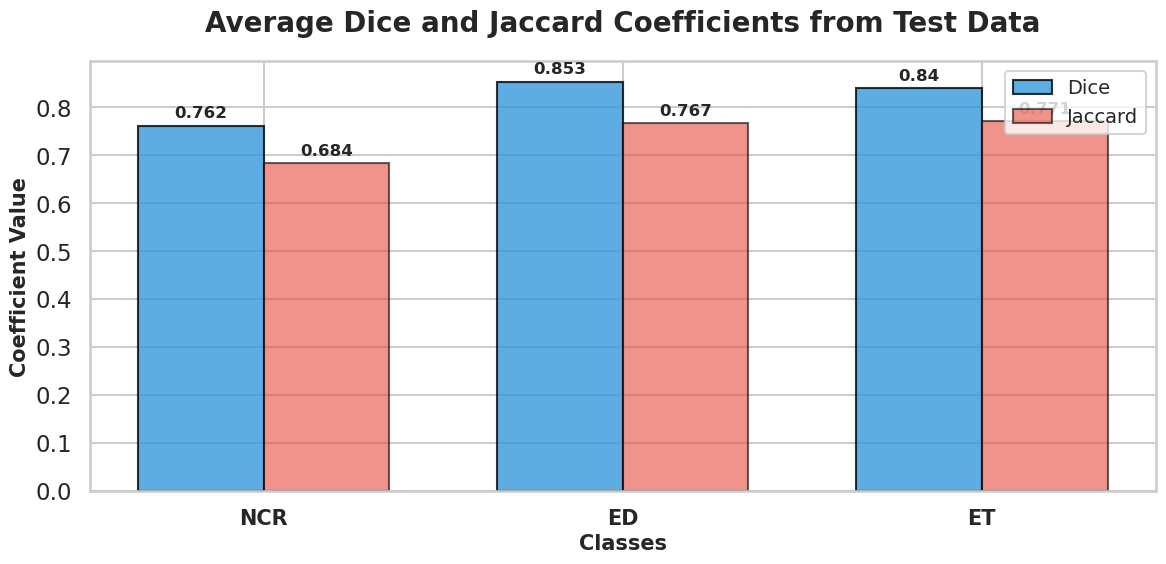

In [84]:
# Подготовка данных
means = val_metics_df.mean()
classes = ['NCR', 'ED', 'ET']
dice_means = [means[f"{cls} dice"] for cls in classes]
jaccard_means = [means[f"{cls} jaccard"] for cls in classes]

bar_width = 0.35
indices = np.arange(len(classes))

# Визуализация
fig, ax = plt.subplots(figsize=(12, 6))

# Визуализируем Dice коэффициенты
dice_bars = ax.bar(indices - bar_width/2, dice_means, bar_width, label='Dice', alpha=0.8, color='#3498db', edgecolor='black')

# Визуализируем Jaccard коэффициенты, но позиционируем их так, чтобы они были "наложены" на Dice
jaccard_bars = ax.bar(indices + bar_width/2, jaccard_means, bar_width, label='Jaccard', alpha=0.6, color='#e74c3c', edgecolor='black')

# Настройка оси X
ax.set_xlabel('Classes', fontsize=15, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=15, weight='bold')
ax.set_title('Average Dice and Jaccard Coefficients from Test Data', fontsize=20, y=1.05, weight='bold')
ax.set_xticks(indices)
ax.set_xticklabels(classes, fontsize=15, fontweight='bold')
ax.legend(fontsize=14, loc='best')

# Улучшения для статьи: делаем границы более видимыми, добавляем значения над столбцами
for bars in [dice_bars, jaccard_bars]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()# attn

# Train history

In [147]:
df = pd.read_csv('~/edu/dyplom_work/brats2020/unet_att/train_log_new.csv')[102:] # attn
df.reset_index(drop=True, inplace=True)# attn

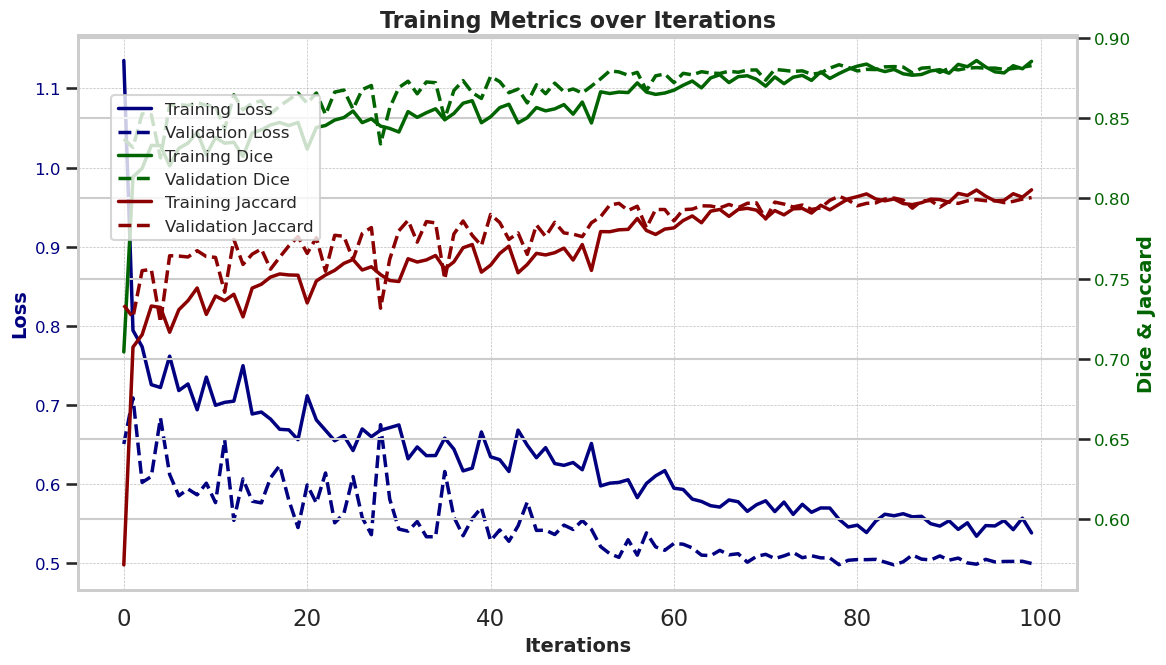

In [148]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_xlabel('Iterations', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', color='navy', fontsize=14, fontweight='bold')
ax1.plot(df["train_loss"], label="Training Loss", color="navy", linewidth=2.5)
ax1.plot(df["val_loss"], label="Validation Loss", color="navy", linewidth=2.5, linestyle='--')
ax1.tick_params(axis='y', labelcolor='navy', labelsize=12)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Dice & Jaccard', color='darkgreen', fontsize=14, fontweight='bold')  # we already handled the x-label with ax
ax2.plot(df["train_dice"], label="Training Dice", color="darkgreen", linewidth=2.5)
ax2.plot(df["val_dice"], label="Validation Dice", color="darkgreen", linewidth=2.5, linestyle='--')
ax2.plot(df["train_jaccard"], label="Training Jaccard", color="darkred", linewidth=2.5)
ax2.plot(df["val_jaccard"], label="Validation Jaccard", color="darkred", linewidth=2.5, linestyle='--')
ax2.tick_params(axis='y', labelcolor='darkgreen', labelsize=12)

# Title
plt.title("Training Metrics over Iterations", fontsize=16, fontweight='bold')

# Grid
ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Legend
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.85), fontsize=12)

# Save the figure (optional, if you want to save it as an image)
# plt.savefig("metrics_graph.png", dpi=300)

plt.show()

In [145]:
df = pd.read_csv('~/edu/dyplom_work/brats2020/vanila_unet/train_log_new.csv')[100:]
df.reset_index(drop=True, inplace=True)# attn

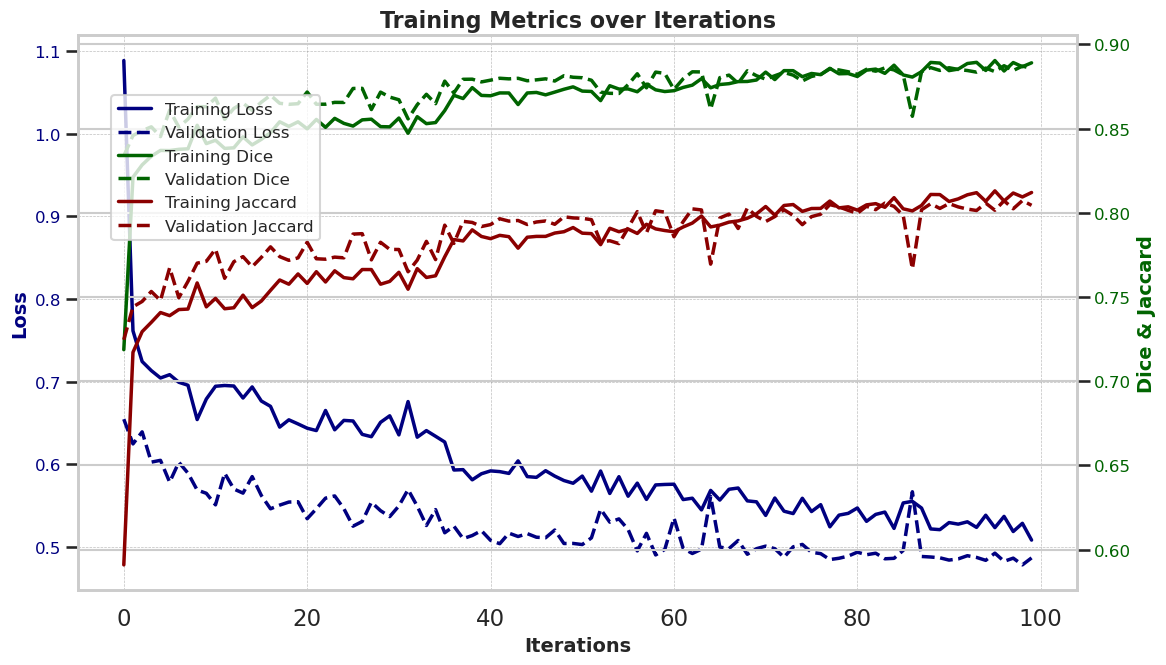

In [146]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_xlabel('Iterations', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', color='navy', fontsize=14, fontweight='bold')
ax1.plot(df["train_loss"], label="Training Loss", color="navy", linewidth=2.5)
ax1.plot(df["val_loss"], label="Validation Loss", color="navy", linewidth=2.5, linestyle='--')
ax1.tick_params(axis='y', labelcolor='navy', labelsize=12)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Dice & Jaccard', color='darkgreen', fontsize=14, fontweight='bold')  # we already handled the x-label with ax
ax2.plot(df["train_dice"], label="Training Dice", color="darkgreen", linewidth=2.5)
ax2.plot(df["val_dice"], label="Validation Dice", color="darkgreen", linewidth=2.5, linestyle='--')
ax2.plot(df["train_jaccard"], label="Training Jaccard", color="darkred", linewidth=2.5)
ax2.plot(df["val_jaccard"], label="Validation Jaccard", color="darkred", linewidth=2.5, linestyle='--')
ax2.tick_params(axis='y', labelcolor='darkgreen', labelsize=12)

# Title
plt.title("Training Metrics over Iterations", fontsize=16, fontweight='bold')

# Grid
ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Legend
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.85), fontsize=12)

# Save the figure (optional, if you want to save it as an image)
# plt.savefig("metrics_graph.png", dpi=300)

plt.show()